In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import seaborn as sns
pd.set_option('display.max_columns',None)

In [2]:
base = pd.read_feather('../features/mini_data/BASE_train.feather')

In [3]:
base.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [2]:
train_df = pd.read_feather('../data/input/train.feather')

In [3]:
def _reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def _label_encoder(data):
    l_data,_ =data.factorize(sort=True)
    if l_data.max()>32000:
        l_data = l_data.astype('int32')
    else:
        l_data = l_data.astype('int16')

    if data.isnull().sum() > 0:
        l_data = np.where(l_data == -1,np.nan,l_data)
    return l_data

In [5]:
train_df = _reduce_mem_usage(train_df)

Mem. usage decreased to 3378.93 Mb (56.2% reduction)


In [6]:
qs = pd.read_csv('../data/input/questions.csv')

In [7]:
lc = pd.read_csv('../data/input/lectures_new.csv')

In [60]:
tag = qs["tags"].str.split(" ",expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
qs = pd.concat([qs,tag],axis=1)
lc['l_type_of'] = _label_encoder(lc['type_of'])
qs = qs.rename(columns={'question_id':'content_id'})
lc = lc.rename(columns={'lecture_id':'content_id'})
qs_lc = pd.concat([qs,lc])
train_df = pd.merge(train_df,qs_lc,on='content_id',how='left')
train_df = _reduce_mem_usage(train_df)

Mem. usage decreased to 11427.83 Mb (21.1% reduction)


In [61]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
0,0,0,115,5692,0,1,3,1,NaN,None,5692.0,3.0,5,151,151,None,None,None,None,None,NaN,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False,5716.0,2.0,5,168,168,None,None,None,None,None,NaN,NaN,NaN
2,2,118363,115,128,0,0,0,1,55000.0,False,128.0,0.0,1,131 149 92,131,149,92,None,None,None,NaN,NaN,NaN
3,3,131167,115,7860,0,3,0,1,19000.0,False,7860.0,0.0,1,131 104 81,131,104,81,None,None,None,NaN,NaN,NaN
4,4,137965,115,7922,0,4,1,1,11000.0,False,7920.0,1.0,1,131 149 92,131,149,92,None,None,None,NaN,NaN,NaN


In [111]:
train_df[(train_df['content_type_id'] == 0) & (train_df['content_id'] != train_df['bundle_id'])]['answered_correctly'].mean()

0.6493674771839443

In [112]:
train_df[(train_df['content_type_id'] == 0)]['answered_correctly'].mean()

0.657406587216255

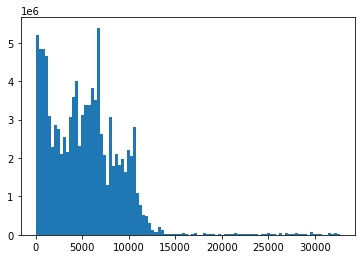

In [89]:
plt.hist(train_df['content_id'],bins=100)
plt.show()

In [ ]:
train_df.

In [122]:
# train_df[train_df['user_id'] == 115]

In [113]:
train_df['part'].value_counts()

5    42436724
2    19383726
6    11097180
3     8870972
4     8368943
1     7907737
7     5235994
Name: part, dtype: int64

In [119]:
train_df[train_df['prior_question_elapsed_time'].isnull()]['part'].value_counts()

5    1452037
2     459081
1     437936
6     312628
4     202821
3     176836
7      80040
Name: part, dtype: int64

In [121]:
train_df[(train_df['prior_question_elapsed_time'].isnull()) & (train_df['content_type_id'] == 0)]['answered_correctly'].mean()

0.6792028791107557

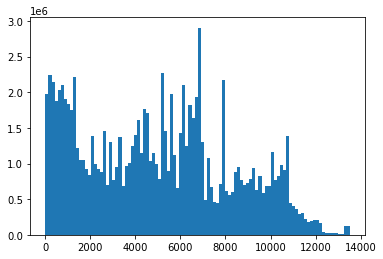

In [96]:
plt.hist(train_df[(train_df['content_type_id'] == 0)]['content_id'],bins=100)
plt.show()

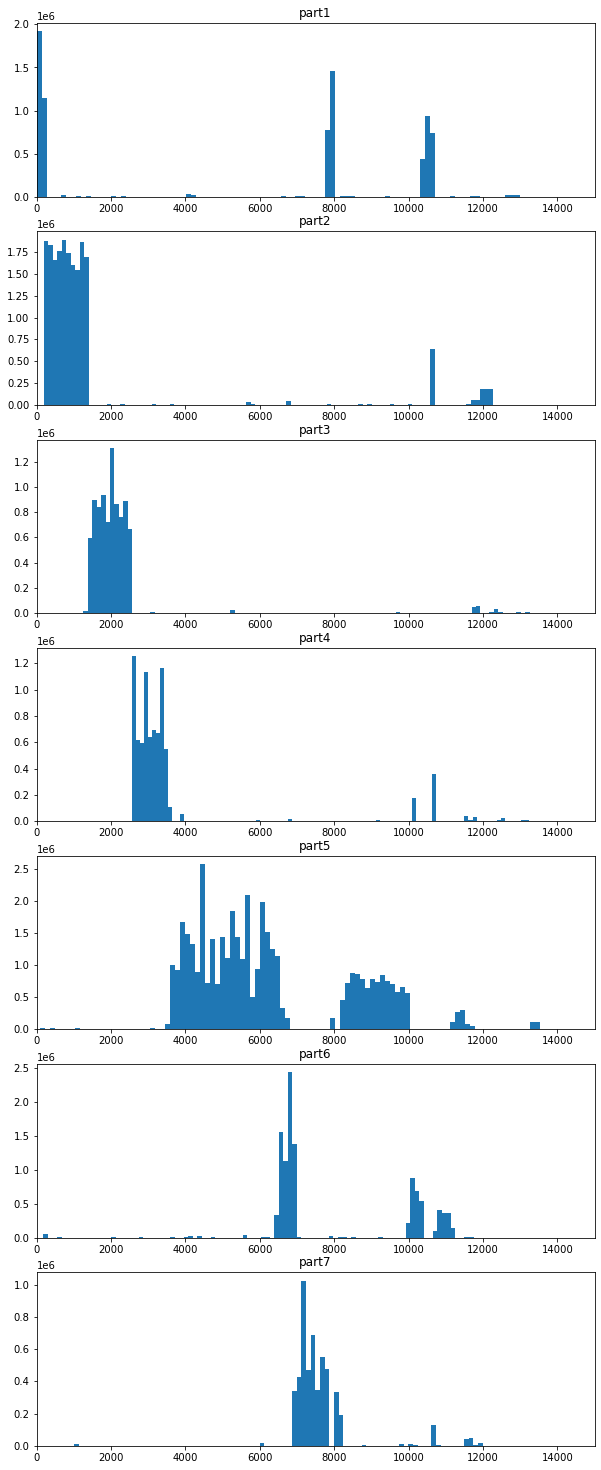

In [107]:
plt.figure(figsize=(10,30))
for part in range(1,8):
    plt.subplot(8,1,part)
    plt.xlim(0, 15000)
    plt.title(f'part{part}')
    plt.hist(train_df[(train_df['content_type_id'] == 0) & (train_df['part'] == part)]['content_id'],bins=100)
plt.show()

In [99]:
train_df[(train_df['content_type_id'] == 0) & (train_df['content_id'] <500)]['part'].value_counts()

2    4577040
1    3065960
5      47060
6      47047
Name: part, dtype: int64

In [ ]:
train_df[(train_df['content_type_id'] == 0) & (train_df['content_id'] <500)]['part'].value_counts()

In [65]:
train_df[train_df['user_id'] == 115]['content_id'].value_counts()

100     2
185     2
7926    2
7897    1
2063    1
156     1
7898    1
25      1
7896    1
7900    1
5716    1
2065    1
2064    1
7962    1
7927    1
7948    1
7882    1
50      1
57      1
6       1
4       1
151     1
7859    1
7901    1
172     1
3363    1
175     1
7876    1
5692    1
7863    1
55      1
7860    1
51      1
7922    1
7984    1
45      1
1278    1
108     1
152     1
3364    1
104     1
167     1
183     1
3365    1
7971    1
128     1
Name: content_id, dtype: int64

In [67]:
FEATURES_LIST = ['BASE','USER_ID','PART','USER_PART','CONTENT','TAGS','USER_READING_PART','TYPE_OF','USER_TYPE_OF','USER_ID_LECTURE','LECTURE_COUNT']

In [70]:
trains = [pd.read_feather(f'../features/mini_data/{feature}_train.feather') for feature in FEATURES_LIST]
train = pd.concat(trains,axis=1)

In [71]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_avg_user,answered_correctly_sum_user,count_user,answered_correctly_avg_part,reading_part,answered_correctly_avg_reading_part,answered_correctly_avg_user_part,answered_correctly_sum_user_part,count_user_part,answered_correctly_avg_content,answered_correctly_sum_content,content_num,answered_correctly_avg_tags1,answered_correctly_avg_user_reading_part,answered_correctly_sum_user_reading_part,count_user_reading_part,answered_correctly_avg_type_of,answered_correctly_avg_user_type_of,answered_correctly_sum_user_type_of,count_user_type_of,lecture_count,lecture_part1_count,lecture_part2_count,lecture_part3_count,lecture_part4_count,lecture_part5_count,lecture_part6_count,lecture_part7_count,lecture_part1_count_cut,answered_correctly_avg_lecture_count_part1,lecture_part2_count_cut,answered_correctly_avg_lecture_count_part2,lecture_part3_count_cut,answered_correctly_avg_lecture_count_part3,lecture_part4_count_cut,answered_correctly_avg_lecture_count_part4,lecture_part5_count_cut,answered_correctly_avg_lecture_count_part5,lecture_part6_count_cut,answered_correctly_avg_lecture_count_part6,lecture_part7_count_cut,answered_correctly_avg_lecture_count_part7
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.602282,1,0.617223,NaN,0,0,0.752778,271,360,0.607741,NaN,0,0,0.647069,NaN,0,0,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,1,0.602282,1,0.617223,0.000000,0,1,0.579035,348,601,0.695563,0.000000,0,1,0.647069,0.000000,0,1,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,2,0.602282,1,0.617223,0.000000,0,2,0.623457,303,486,0.610308,0.000000,0,2,0.647069,0.000000,0,2,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.333333,1,3,0.701379,0,0.686168,NaN,0,0,0.670373,1869,2788,0.735485,NaN,0,0,0.647069,0.333333,1,3,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.250000,1,4,0.602282,1,0.617223,0.333333,1,3,0.828957,1168,1409,0.610358,0.333333,1,3,0.647069,0.250000,1,4,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712


In [77]:
valids = [pd.read_feather(f'../features/mini_data/{feature}_valid.feather') for feature in FEATURES_LIST]
valid = pd.concat(valids,axis=1)

In [82]:
valid[valid['user_id'].isin(train['user_id'].unique())]['user_id'].nunique()

9130

In [85]:
train[train['user_id'] == 44331]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_avg_user,answered_correctly_sum_user,count_user,answered_correctly_avg_part,reading_part,answered_correctly_avg_reading_part,answered_correctly_avg_user_part,answered_correctly_sum_user_part,count_user_part,answered_correctly_avg_content,answered_correctly_sum_content,content_num,answered_correctly_avg_tags1,answered_correctly_avg_user_reading_part,answered_correctly_sum_user_reading_part,count_user_reading_part,answered_correctly_avg_type_of,answered_correctly_avg_user_type_of,answered_correctly_sum_user_type_of,count_user_type_of,lecture_count,lecture_part1_count,lecture_part2_count,lecture_part3_count,lecture_part4_count,lecture_part5_count,lecture_part6_count,lecture_part7_count,lecture_part1_count_cut,answered_correctly_avg_lecture_count_part1,lecture_part2_count_cut,answered_correctly_avg_lecture_count_part2,lecture_part3_count_cut,answered_correctly_avg_lecture_count_part3,lecture_part4_count_cut,answered_correctly_avg_lecture_count_part4,lecture_part5_count_cut,answered_correctly_avg_lecture_count_part5,lecture_part6_count_cut,answered_correctly_avg_lecture_count_part6,lecture_part7_count_cut,answered_correctly_avg_lecture_count_part7
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.602282,1,0.617223,NaN,0,0,0.752778,271,360,0.607741,NaN,0,0,0.647069,NaN,0,0,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,1,0.602282,1,0.617223,0.000000,0,1,0.579035,348,601,0.695563,0.000000,0,1,0.647069,0.000000,0,1,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,2,0.602282,1,0.617223,0.000000,0,2,0.623457,303,486,0.610308,0.000000,0,2,0.647069,0.000000,0,2,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.333333,1,3,0.701379,0,0.686168,NaN,0,0,0.670373,1869,2788,0.735485,NaN,0,0,0.647069,0.333333,1,3,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.250000,1,4,0.602282,1,0.617223,0.333333,1,3,0.828957,1168,1409,0.610358,0.333333,1,3,0.647069,0.250000,1,4,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,8800,4661010350,44331,6099,0,193,1,1,27000.0,1.0,6099.0,1.0,5,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.584775,169,289,0.602282,1,0.617223,0.639344,39,61,0.662541,1017,1535,0.598060,0.554455,56,101,0.647069,0.580420,166,286,5,1,0,0,0,2,2,0,1,0.676222,0,0.620921,0,0.629843,0,0.624334,1,0.669280,1,0.676810,0,0.641712
290,8801,4661039349,44331,10394,0,194,2,1,51000.0,1.0,10394.0,2.0,1,131 5 38,131.0,5.0,38.0,NaN,NaN,NaN,NaN,None,NaN,0.586207,170,290,0.728872,0,0.686168,0.709677,44,62,0.787234,370,470,0.789667,0.601064,113,188,0.647069,0.581882,167,287,5,1,0,0,0,2,2,0,1,0.676222,0,0.620921,0,0.629843,0,0.624334,1,0.669280,1,0.676810,0,0.641712
291,8802,4661118198,44331,1404,0,195,0,1,20000.0,1.0,1403.0,0.0,3,136 38 29,136.0,38.0,29.0,NaN,NaN,NaN,NaN,None,NaN,0.587629,171,291,0.691563,0,0.686168,0.543860,31,57,0.777328,

In [84]:
train[train['answered_correctly_avg_user_reading_part'].isnull()]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_avg_user,answered_correctly_sum_user,count_user,answered_correctly_avg_part,reading_part,answered_correctly_avg_reading_part,answered_correctly_avg_user_part,answered_correctly_sum_user_part,count_user_part,answered_correctly_avg_content,answered_correctly_sum_content,content_num,answered_correctly_avg_tags1,answered_correctly_avg_user_reading_part,answered_correctly_sum_user_reading_part,count_user_reading_part,answered_correctly_avg_type_of,answered_correctly_avg_user_type_of,answered_correctly_sum_user_type_of,count_user_type_of,lecture_count,lecture_part1_count,lecture_part2_count,lecture_part3_count,lecture_part4_count,lecture_part5_count,lecture_part6_count,lecture_part7_count,lecture_part1_count_cut,answered_correctly_avg_lecture_count_part1,lecture_part2_count_cut,answered_correctly_avg_lecture_count_part2,lecture_part3_count_cut,answered_correctly_avg_lecture_count_part3,lecture_part4_count_cut,answered_correctly_avg_lecture_count_part4,lecture_part5_count_cut,answered_correctly_avg_lecture_count_part5,lecture_part6_count_cut,answered_correctly_avg_lecture_count_part6,lecture_part7_count_cut,answered_correctly_avg_lecture_count_part7
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.602282,1,0.617223,NaN,0,0,0.752778,271,360,0.607741,NaN,0,0,0.647069,NaN,0,0,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.333333,1,3,0.701379,0,0.686168,NaN,0,0,0.670373,1869,2788,0.735485,NaN,0,0,0.647069,0.333333,1,3,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
294,8835,0,46886,5059,0,0,1,1,NaN,NaN,5059.0,1.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.602282,1,0.617223,NaN,0,0,0.591304,68,115,0.610308,NaN,0,0,0.647069,NaN,0,0,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
295,8836,13010696,46886,1207,0,1,0,0,19000.0,0.0,1207.0,1.0,2,2 107 162 38 102,2.0,107.0,162.0,38.0,102.0,NaN,NaN,None,NaN,1.000000,1,1,0.701379,0,0.686168,NaN,0,0,0.577268,1158,2006,0.682942,NaN,0,0,0.647069,1.000000,1,1,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
324,16578,0,146403,7900,0,0,0,1,NaN,NaN,7900.0,0.0,1,131 93 81,131.0,93.0,81.0,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.728872,0,0.686168,NaN,0,0,0.824937,20027,24277,0.789667,NaN,0,0,0.647069,NaN,0,0,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8684452,101221820,598231992,2147261668,4492,0,8,2,1,28666.0,0.0,4492.0,2.0,5,80,80.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.687500,11,16,0.602282,1,0.617223,NaN,0,0,0.451518,10100,22369,0.551976,NaN,0,0,0.647069,0.687500,11,16,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
8684536,101228510,0,2147447441,7900,0,0,0,1,NaN,NaN,7900.0,0.0,1,131 93 81,131.0,93.0,81.0,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.728872,0,0.686168,NaN,0,0,0.824937,20027,24277,0.789667,NaN,0,0,0.647069,NaN,0,0,0,0,0,0,0,0,0,0,0,0.625019,0,0.620921,0,0.629843,0,0.624334,0,0.607119,0,0.624098,0,0.641712
8684552,101228526,307009,2147447441,4492,0,8,3,0,16333.0,0.0,4492.0,2.0,5,80,80.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.312500,5,16,0.602282,1,0.617223,NaN,0,0,0.451518,10100,22369,0.551976,NaN,0,0,0.647069,0.312500,5,16,0,0,0,0,0,0,0,0,0,

In [78]:
train['content_id']

row_id
0
0
timestamp
0
0
user_id
0
0
content_id
0
0
content_type_id
0
0
task_container_id
0
0
user_answer
0
0
answered_correctly
0
0
prior_question_elapsed_time
52522
11211
prior_question_had_explanation
52522
11211
bundle_id
115975
32544
correct_answer
115975
32544
part
0
0
tags
115975
32544
tags1
115975
32544
tags2
4251311
1241969
tags3
4518542
1320482
tags4
6408560
1838873
tags5
7836725
2247490
tags6
8605013
2462531
tag
8568610
2452951
type_of
8568610
2452951
l_type_of
8568610
2452951
answered_correctly_avg_user
52355
11179
answered_correctly_sum_user
0
0
count_user
0
0
answered_correctly_avg_part
0
0
reading_part
0
0
answered_correctly_avg_reading_part
0
0
answered_correctly_avg_user_part
252157
55608
answered_correctly_sum_user_part
0
0
count_user_part
0
0
answered_correctly_avg_content
0
1
answered_correctly_sum_content
0
1
content_num
0
1
answered_correctly_avg_tags1
115975
32544
answered_correctly_avg_user_reading_part
100609
21590
answered_correctly_sum_user_reading_part
0
0
c

In [21]:
train_df[train_df['content_type_id'] == 1].head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
92,89,653762,2746,6808,1,14,-1,-1,NaN,False,6804.0,1.0,6,27,27,None,None,None,None,None,NaN,NaN,NaN
93,89,653762,2746,6808,1,14,-1,-1,NaN,False,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.0,intention,1.0
123,117,10183847,5382,16736,1,21,-1,-1,NaN,False,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,concept,0.0
220,212,1424348597,5382,30207,1,104,-1,-1,NaN,False,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,concept,0.0
224,216,1425557777,5382,18545,1,121,-1,-1,NaN,False,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,concept,0.0


In [20]:
train_df[train_df['user_id'] == 372519499]['answered_correctly'][-1000:].mean()

0.744

In [37]:
lecture_part1_num_dict_list = [defaultdict(int) for _ in range(8)]

In [40]:
lecture_part1_num_dict_list

[defaultdict(int, {}),
 defaultdict(int, {}),
 defaultdict(int, {}),
 defaultdict(int, {}),
 defaultdict(int, {}),
 defaultdict(int, {}),
 defaultdict(int, {}),
 defaultdict(int, {})]

In [36]:
row[2]

2

In [23]:
from collections import defaultdict
dd = defaultdict(int)

In [30]:
def f(dd2):
    dd2[10] = 2

In [31]:
f(dd)

In [32]:
dd

defaultdict(int, {10: 2})

In [14]:
train_df['bundle_id'].nunique()

4058

In [16]:
train_df['bundle_id'].value_counts()

10688.0    701034
7216.0     641198
2064.0     528129
3364.0     517722
2946.0     502766
            ...  
3670.0         72
7848.0         58
3578.0         58
7548.0         34
1484.0          3
Name: bundle_id, Length: 4058, dtype: int64

In [ ]:
cols = ['tag1','tag2','bundle_id',['bundle_id','tag1'],'task_container_id']
for col in cols:
    

In [105]:
train_df[(train_df['prior_question_had_explanation'] != 0) & ((train_df['prior_question_had_explanation'] != 1))]['part'].value_counts()

5    225622
1    166041
2      2265
6       844
4       202
3        76
7        72
Name: part, dtype: int64

In [97]:
train_df['user_id'].value_counts()[10001:10002]

363123680    2047
Name: user_id, dtype: int64

In [31]:
train_df.loc[train_df['prior_question_had_explanation'] == False , 'prior_question_had_explanation'] = 0
train_df.loc[train_df['prior_question_had_explanation'] == True , 'prior_question_had_explanation'] = 1

In [98]:
train_df[(train_df['user_id'] == 363123680)]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
17255939,16907856,0,363123680,175,0,0,0,0,NaN,None,175.0,2.0,1,9 10 92,9,10,92,None,None,None,NaN,NaN,NaN
17255940,16907857,38157,363123680,1278,0,2,3,1,23000.0,0,1278.0,3.0,2,143 140 81 29,143,140,81,29,None,None,NaN,NaN,NaN
17255941,16907858,131112,363123680,2063,0,3,3,0,35000.0,0,2064.0,0.0,3,136 92 29,136,92,29,None,None,None,NaN,NaN,NaN
17255942,16907859,131112,363123680,2065,0,3,1,0,35000.0,0,2064.0,2.0,3,136 162 92 29,136,162,92,29,None,None,NaN,NaN,NaN
17255943,16907860,131112,363123680,2064,0,3,2,0,35000.0,0,2064.0,1.0,3,157 92 29,157,92,29,None,None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17257981,16909846,46741157917,363123680,11481,0,1703,3,1,47000.0,1,11480.0,3.0,5,64,64,None,None,None,None,None,NaN,NaN,NaN
17257982,16909847,46741249869,363123680,8174,0,1704,2,1,31000.0,1,8176.0,2.0,5,134,134,None,None,None,None,None,NaN,NaN,NaN
17257983,16909848,46741288225,363123680,8461,0,1705,1,0,17000.0,1,8464.0,3.0,5,72,72,None,None,None,None,None,NaN,NaN,NaN
17257984,16909848,46741288225,363123680,8461,0,1705,1,0,17000.0,1,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173.0,concept,0.0


In [99]:
train_df[(train_df['user_id'] == 363123680)][['part','answered_correctly']].groupby('part').mean()

,answered_correctly
part,
1,0.404959
2,0.529551
3,0.489362
4,0.500000
5,0.577281
6,0.600000
7,0.291667


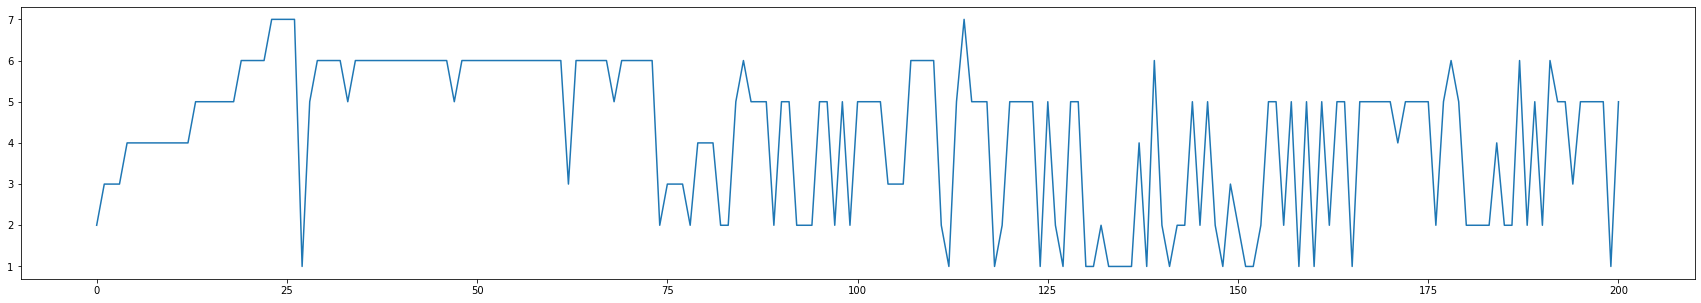

In [100]:
plt.figure(figsize=(30,5))
# plt.plot(train_df[(train_df['user_id'] == 455973631)]['prior_question_had_explanation'][:300])
plt.plot(train_df[(train_df['user_id'] == 363123680) & (train_df['prior_question_had_explanation'] == 0)]['part'].reset_index(drop=True))
plt.show()

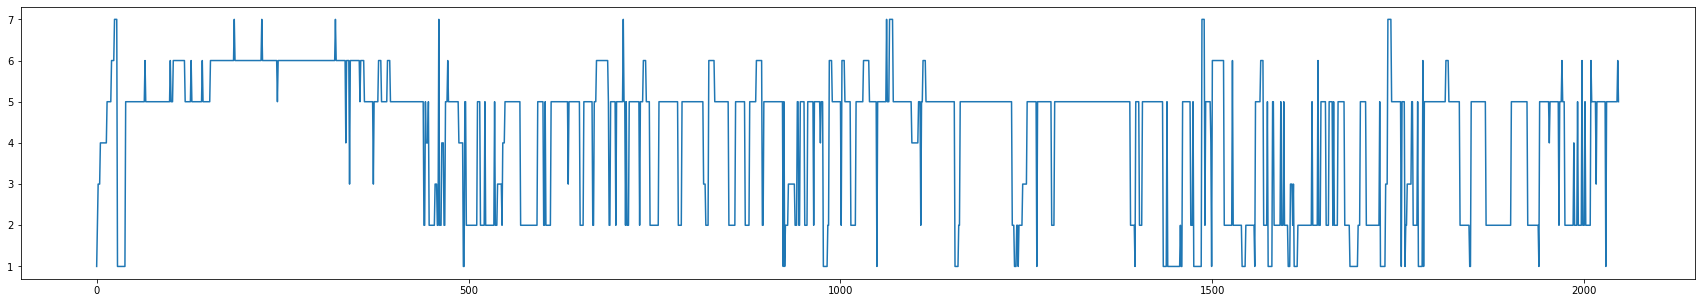

In [101]:
plt.figure(figsize=(30,5))
plt.plot(train_df[(train_df['user_id'] == 363123680)]['part'].reset_index(drop=True))
plt.show()

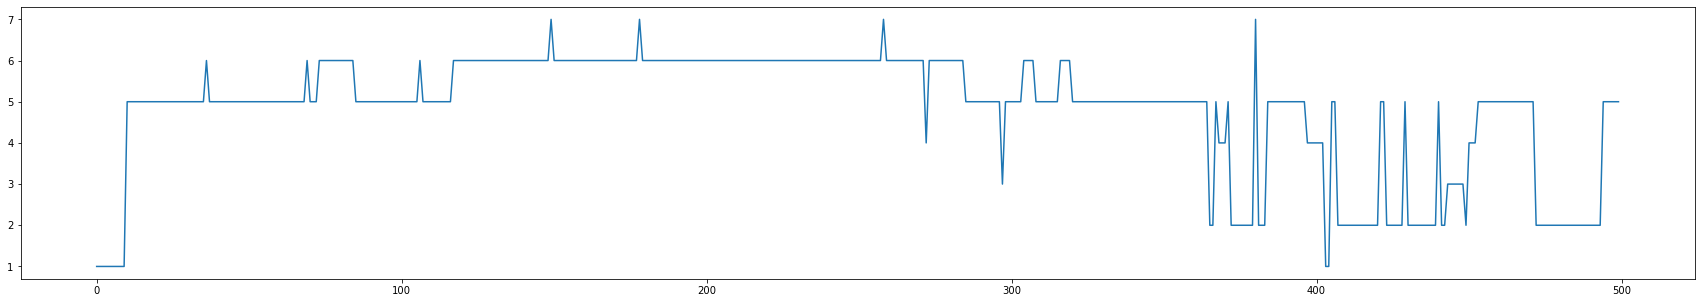

In [102]:
plt.figure(figsize=(30,5))
# plt.plot(train_df[(train_df['user_id'] == 455973631)]['prior_question_had_explanation'][:300])
plt.plot(train_df[(train_df['user_id'] == 363123680) & (train_df['prior_question_had_explanation'] == 1)]['part'][:500].reset_index(drop=True))
plt.show()

In [60]:
train_df[(train_df['user_id'] == 455973631) & (train_df['prior_question_had_explanation'] == 1)]['part'].value_counts()

3    4221
2    3378
5    2951
6    2554
4    2273
1     583
7     377
Name: part, dtype: int64

In [11]:
train_df = train_df[train_df['answered_correctly'] != -1]

In [12]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
0,0,0,115,5692,0,1,3,1,NaN,None,5692.0,3.0,5,151,151,None,None,None,None,None,NaN,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False,5716.0,2.0,5,168,168,None,None,None,None,None,NaN,NaN,NaN
2,2,118363,115,128,0,0,0,1,55000.0,False,128.0,0.0,1,131 149 92,131,149,92,None,None,None,NaN,NaN,NaN
3,3,131167,115,7860,0,3,0,1,19000.0,False,7860.0,0.0,1,131 104 81,131,104,81,None,None,None,NaN,NaN,NaN
4,4,137965,115,7922,0,4,1,1,11000.0,False,7920.0,1.0,1,131 149 92,131,149,92,None,None,None,NaN,NaN,NaN


In [13]:
few_content = train_df['content_id'].value_counts().sort_values().head(30).index.values

In [14]:
train_df[train_df['content_id'].isin(few_content)]['part'].value_counts()

7    224
5    124
6      5
3      3
Name: part, dtype: int64

In [15]:
train_df['part'].value_counts()

5    41210309
2    18926910
6    10785396
3     8694212
4     8166324
1     7635842
7     5156026
Name: part, dtype: int64

In [17]:
for i in range(1,8):
    print(f'part{i}')
    print(train_df[train_df['part'] == i]['content_id'].nunique())

part1
1015
part2
1664
part3
1568
part4
1449
part5
5547
part6
1236
part7
1173


In [18]:
train_df[train_df['content_id'].isin(few_content)]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
744545,729633,1032782533,15375317,4618,0,274,1,1,18000.0,True,4616.0,1.0,5,79,79,None,None,None,None,None,NaN,NaN,NaN
3256736,3190666,2046332289,68437470,7139,0,251,2,1,127250.0,True,7136.0,2.0,7,18 16 21,18,16,21,None,None,None,NaN,NaN,NaN
3256737,3190667,2046332289,68437470,7137,0,251,0,1,127250.0,True,7136.0,0.0,7,118 16 21,118,16,21,None,None,None,NaN,NaN,NaN
3256738,3190668,2046332289,68437470,7138,0,251,2,1,127250.0,True,7136.0,2.0,7,145 16 21,145,16,21,None,None,None,NaN,NaN,NaN
4585479,4492995,3610286625,94962323,4741,0,780,0,1,11000.0,True,4740.0,0.0,5,8,8,None,None,None,None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101716399,99676695,1640088301,2116187045,3572,0,1626,0,1,15000.0,True,3572.0,0.0,5,8,8,None,None,None,None,None,NaN,NaN,NaN
101716621,99676913,1702711594,2116187045,4656,0,1801,0,1,7000.0,True,4656.0,0.0,5,79,79,None,None,None,None,None,NaN,NaN,NaN
101716912,99677201,1812182261,2116187045,4741,0,2009,0,1,20000.0,True,4740.0,0.0,5,8,8,None,None,None,None,None,NaN,NaN,NaN
101717142,99677431,2084254766,2116187045,6236,0,2229,0,1,20000.0,True,6236.0,0.0,5,8,8,None,None,None,None,None,NaN,NaN,NaN


In [19]:
train_df[train_df['content_id'].isin(few_content)]['answered_correctly'].mean()

0.8230337078651685

In [22]:
content_id_ans = train_df[['content_id','answered_correctly']].groupby('content_id').mean()

In [25]:
content_id_ans.sort_values('answered_correctly')

,answered_correctly
content_id,
1485,0.000000
10007,0.000000
1484,0.000000
1486,0.000000
10062,0.091752
...,...
10006,1.000000
12809,1.000000
12806,1.000000


In [73]:
df = pd.DataFrame()
content_ids = []
content_mean = []
content_num = []
num = 100
for i in tqdm(range(0,num)):
    content_id = train_df['content_id'].value_counts().sort_values(ascending=False).index[i]
    content_ids.append(content_id)
    content_mean.append(train_df[train_df['content_id'] == content_id]['answered_correctly'].mean())

df['content_id'] = content_ids
df['ans_mean'] = content_mean
df['num'] = train_df['content_id'].value_counts().sort_values(ascending=False).iloc[:num].values

In [74]:
train_df['content_id'].value_counts().sort_values(ascending=False)

10688    253996
6116     213605
6173     202106
4120     199372
175      195861
          ...  
10005         1
5823          1
1485          1
1484          1
1486          1
Name: content_id, Length: 13523, dtype: int64

In [76]:
train_df[['content_id','answered_correctly']].groupby('content_id').mean().reset_index()

,content_id,answered_correctly
0,0,0.907721
1,1,0.890646
2,2,0.554281
3,3,0.779437
4,4,0.613215
...,...,...
13518,13518,0.786866
13519,13519,0.571429
13520,13520,0.672474
13521,13521,0.808046


In [84]:
df = pd.DataFrame(train_df['content_id'].value_counts().sort_values(ascending=False)).reset_index()

In [85]:
df.columns = ['content_id','num']

In [87]:
df2 = train_df[['content_id','answered_correctly']].groupby('content_id').mean().reset_index()

In [89]:
df = pd.merge(df,df2,on='content_id',how='left')

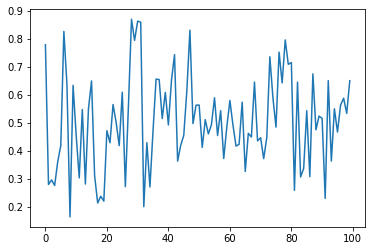

In [94]:
plt.plot(df['answered_correctly'].iloc[:100])

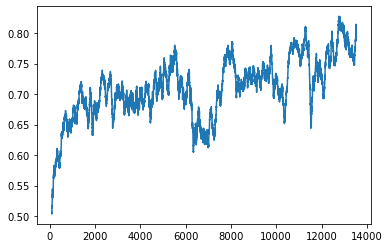

In [101]:
plt.plot(df['answered_correctly'].rolling(100).mean())
plt.show()

In [106]:
df.iloc[6200:7000]

,content_id,num,answered_correctly
6200,10827,5160,0.357171
6201,10830,5160,0.517636
6202,8902,5159,0.728823
6203,9197,5158,0.283637
6204,4649,5157,0.597246
...,...,...,...
6995,8427,4654,0.482381
6996,9369,4654,0.710572
6997,5235,4653,0.575113
6998,9673,4653,0.568450


In [110]:
qs_lc['content_id'].nunique()

13783

In [116]:
df = train_df[['content_id','answered_correctly']].groupby('content_id').mean()

In [118]:
df.columns = ['content_id_ans_mean']

In [124]:
df = train_df[train_df['user_id'].isin([115,2147482888])]
df = df[['user_id','answered_correctly','content_id']]
encoded = (df.groupby(['user_id','content_id'])['answered_correctly']
           .expanding().agg(['mean','sum']).groupby('content_id').shift(1))

# encoded = encoded.reset_index().sort_values('level_2').reset_index(drop=True)

In [133]:
encoded = encoded.reset_index().sort_values('level_2').reset_index(drop=True).fillna(0)

In [135]:
encoded.columns = ['user_id', 'content_id', 'level_2', 'content_id_user_mean', 'content_id_user_sum']

Index(['user_id', 'content_id', 'level_2', 'mean', 'sum'], dtype='object')

In [136]:
encoded

,user_id,content_id,level_2,mean,sum
0,115,5692,0,0.0,0.0
1,115,5716,1,0.0,0.0
2,115,128,2,0.0,0.0
3,115,7860,3,0.0,0.0
4,115,7922,4,0.0,0.0
...,...,...,...,...,...
72,2147482888,3586,103301271,0.0,0.0
73,2147482888,6341,103301272,0.0,0.0
74,2147482888,4212,103301273,0.0,0.0
75,2147482888,6343,103301274,0.0,0.0
